In [71]:
# 0. Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV

# Set seed
random.seed(12515515) # NYU N-number

# Load the data
df = pd.read_csv('musicData.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [72]:
# Preprocessing
df = df.dropna()  # Drop rows with any NaN values

# Impute missing 'tempo' values like '?'
df['tempo'] = df['tempo'].replace('?', np.nan)  # Replace '?' with NaN
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')  # Convert to float, coercing errors to NaN
df['tempo'] = df['tempo'].fillna(df['tempo'].median())  # Impute missing values with the median

# # Impute missing 'duration_ms' values
df['duration_ms'] = df['duration_ms'].replace(-1, np.nan)  # Replace -1 with NaN
df['duration_ms'] = df['duration_ms'].fillna(df['duration_ms'].median())  # Impute missing values with the median

# One-hot encode 'key'
key_dummies = pd.get_dummies(df['key'], prefix='key', dtype=int)

# One-hot encode 'mode'
mode_dummies = pd.get_dummies(df['mode'], prefix='mode', dtype=int)

# Concatenate the new dummies to the dataframe
df = pd.concat([df, key_dummies, mode_dummies], axis=1)

# Encode target variable 'Genre'
label_encoder = LabelEncoder()
df['music_genre_encoded'] = label_encoder.fit_transform(df['music_genre'])

# Drop unnecessary columns, including original 'key' and 'mode'
X = df.drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre', 'music_genre_encoded', 'key', 'mode'])
y = df['music_genre_encoded']

display(X.info())
display(y.info())

# Standardize the continuous features (not one-hot encoded)
scaler = StandardScaler()
X.iloc[:, :11] = scaler.fit_transform(X.iloc[:, :11])  # The first 11 columns are continuous features

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 50004
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       50000 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   liveness          50000 non-null  float64
 7   loudness          50000 non-null  float64
 8   speechiness       50000 non-null  float64
 9   tempo             50000 non-null  float64
 10  valence           50000 non-null  float64
 11  key_A             50000 non-null  int32  
 12  key_A#            50000 non-null  int32  
 13  key_B             50000 non-null  int32  
 14  key_C             50000 non-null  int32  
 15  key_C#            50000 non-null  int32  
 16  key_D             50000 non-null  int32  
 17

None

<class 'pandas.core.series.Series'>
Index: 50000 entries, 0 to 50004
Series name: music_genre_encoded
Non-Null Count  Dtype
--------------  -----
50000 non-null  int32
dtypes: int32(1)
memory usage: 585.9 KB


None

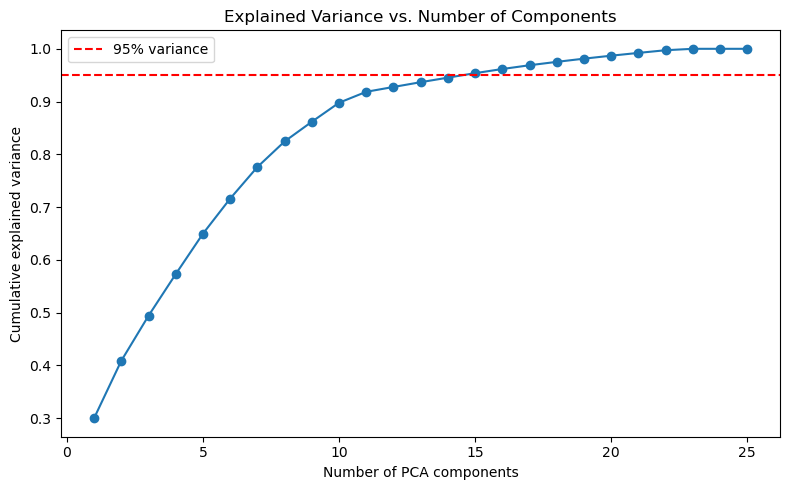

Number of components to explain 95% variance: 15


In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend()
plt.tight_layout()
plt.show()

# Number of factors that account for 95% of the variance (Eigenvalues that 
# add up to 95% of the Eigensum. To account for at least 95% of the variability 
print(f"Number of components to explain 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")

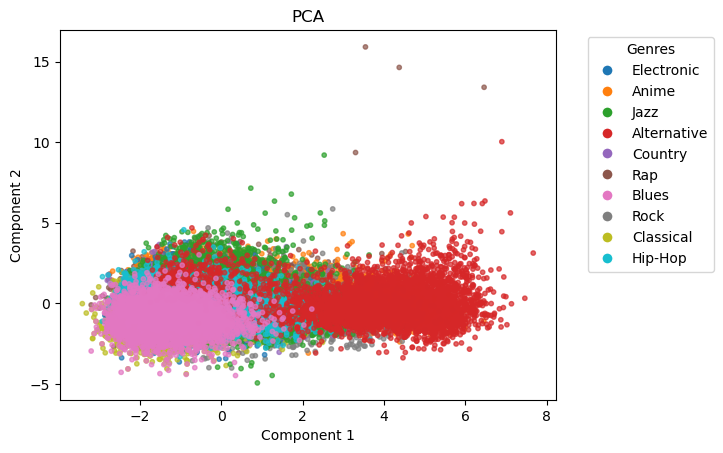

In [74]:
# PCA with the best number of components
pca = PCA(n_components=15)
pca.fit(X)
X_pca = pca.transform(X)

# Map encoded labels back to genre names
genre_labels = label_encoder.inverse_transform(y.unique())
encoded_labels = y.unique()

# Define a colormap with 10 distinct colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cmap = ListedColormap(colors)

# Scatter plot of PCA
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, s=10, alpha=0.7)
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                       markerfacecolor=cmap(i), markersize=8) 
           for i in range(len(encoded_labels))]
plt.legend(handles, genre_labels, title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

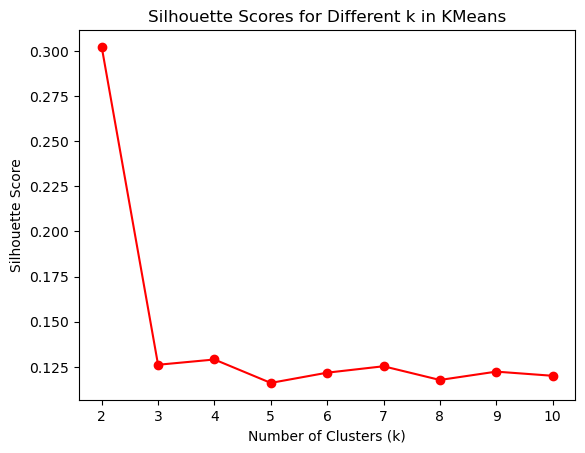

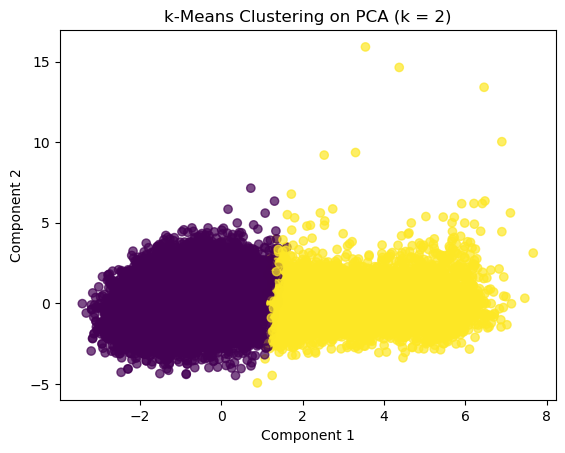

In [75]:
# Clustering
# KMeans clustering
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(k_range, silhouette_scores, 'r-o')
plt.title("Silhouette Scores for Different k in KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Find the best number of clusters (k) with the highest silhouette score
optimal_k = np.argmax(silhouette_scores) + 2  # +2 because k starts from 2

# Apply k-means with optimal_k
kmeans = KMeans(n_clusters=optimal_k, n_init='auto')
clusters = kmeans.fit_predict(X_pca)

# Plot the PCA points with cluster colors
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, alpha=0.7)
plt.title(f"k-Means Clustering on PCA (k = {optimal_k})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [76]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42, stratify=y)

# Check the distribution of the target variable in the training set and test set
print("Training set distribution:\n", y_train.value_counts())
print("Test set distribution:\n", y_test.value_counts())


Training set distribution:
 music_genre_encoded
1    4500
6    4500
2    4500
8    4500
7    4500
3    4500
5    4500
4    4500
9    4500
0    4500
Name: count, dtype: int64
Test set distribution:
 music_genre_encoded
7    500
2    500
3    500
9    500
1    500
8    500
0    500
5    500
4    500
6    500
Name: count, dtype: int64


In [77]:
# Classification model: Random Forest

# Hyperparameter tuning (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_features': ['sqrt', 0.5],  # Number of features to consider at each split
    'max_depth': [None, 20],  # Maximum depth of the tree
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True]  # Whether bootstrap samples are used when building trees
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',  # Metric to optimize
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Print progress
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.2f}")

# Accuracy
y_pred = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Get the AUROC (OVR)
y_score = best_model.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)

# Compute AUROC using One-vs-Rest (OvR) strategy
auc_score_ovr = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
print(f"Overall AUROC (OvR): {auc_score_ovr:.2f}")



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.5228222222222222
Test Set Accuracy: 0.53
Accuracy: 0.53
Overall AUROC (OvR): 0.91


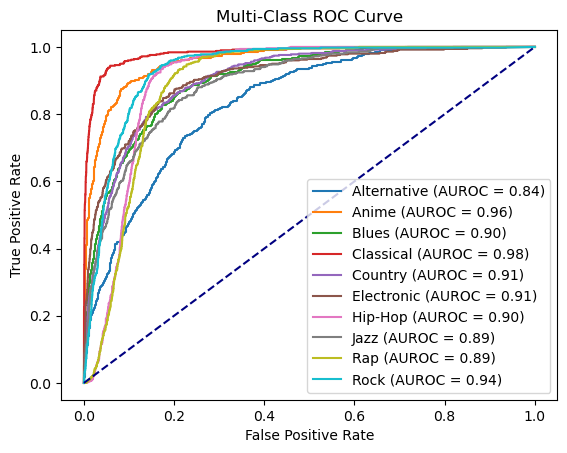

In [78]:
# Plot the ROC curve for each class
from sklearn.metrics import roc_curve, auc
# Map encoded class labels back to genre names
genre_labels = label_encoder.inverse_transform(best_model.classes_)

# Plot the ROC curve for each class
for i, genre in enumerate(genre_labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)  # Compute the AUROC
    plt.plot(fpr, tpr, label=f'{genre} (AUROC = {roc_auc:.2f})')  # Use genre name in the legend

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Add titles and labels
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Feature importances: [0.18218279 0.10068784 0.07428254 0.076297   0.0404959  0.06152889
 0.08142125 0.10507922 0.06761922 0.05359426 0.0415244  0.02639051
 0.02827247 0.02619335 0.03443037]


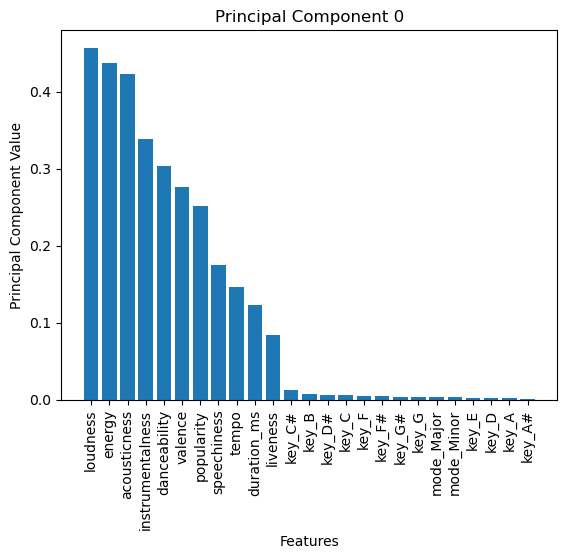

In [79]:
# Find the most important features
# What you think is the most important factor that underlies your classification success

# Get feature importances from the trained model
pca_feature_importances = best_model.feature_importances_
print(f"Feature importances: {pca_feature_importances}")

# Most important feature is the first PCA component
# Get absolute values of component values for the first principal component sorted
pc_values = np.abs(pca.components_[0])
sorted_indices = np.argsort(pc_values)[::-1]  # Sort in descending order
sorted_features = X.columns[sorted_indices]
sorted_pc_values = pc_values[sorted_indices]

plt.bar(sorted_features, sorted_pc_values)
plt.title(f'Principal Component 0')
plt.xlabel('Features')
plt.ylabel('Principal Component Value')
plt.xticks(rotation=90)
plt.show()

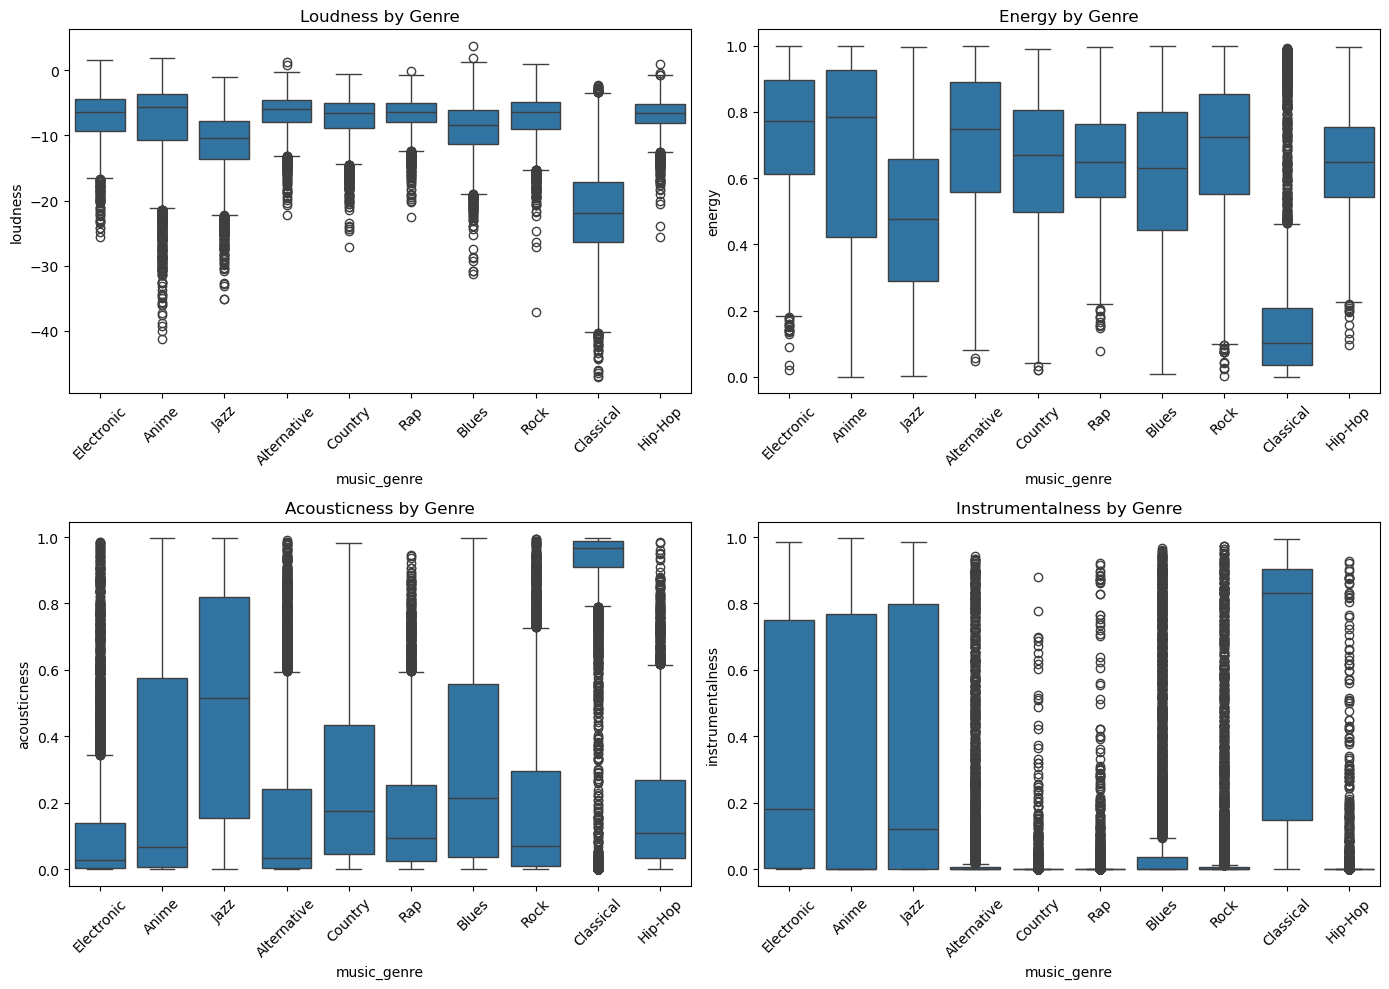

In [83]:
# Extra credit
import seaborn as sns

# Plot each feature separately as a boxplot
features_to_plot = ['loudness', 'energy', 'acousticness', 'instrumentalness']

# Create individual boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=df, x='music_genre', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature.capitalize()} by Genre')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()